### Deep Convolutional Generative Adversarial Network (DCGAN)

![](https://sthalles.github.io/assets/dcgan/GANs.png)

Reference Paper: [Deep Convolutional Generative Adversarial Network (DCGAN) ](https://arxiv.org/abs/1511.06434)

Blog: [A Short Introduction to Generative Adversarial Networks
](https://sthalles.github.io/intro-to-gans/)


#### Changes

* The code in this blog was written with Tensorflow_v1, I rewrote the code using `Tensorflow_v2`.
* I modified the code to work only for [The Street View House Numbers (SVHN)](http://ufldl.stanford.edu/housenumbers/) dataset. This dataset is not available in `utils` package now. Instead, the dataset was collected from `tfds` dataset package ('huggingface:svhn/cropped_digit').
* Auxiliary functions were modified to provide compatibility with TF.v2
* Loss functions and optimizers have been modified as in [TF: Deep Convolutional Generative Adversarial Network](https://www.tensorflow.org/tutorials/generative/dcgan) tutorial to differ from the reference article.



In the DCGAN paper, the authors describe the combination of some deep learning techniques as key for training GANs. These techniques include: the all convolutional net and (ii) Batch Normalization (BN).

The first emphasizes strided convolutions (instead of pooling layers) for both: increasing and decreasing feature’s spatial dimensions. And the second normalizes the feature vectors to have zero mean and unit variance in all layers. This helps to stabilize learning and to deal with poor weight initialization problems.

![](https://sthalles.github.io/assets/dcgan/generator-model.png)

In [ ]:
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import PIL
import gzip
import zipfile
import keras.utils
import tensorflow_datasets as tfds

%matplotlib inline

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 5.7 MB/s eta 0:00:00


In [ ]:
DATASET = 'CelebFaces Attributes (CelebA) Dataset'   # CelebFaces Attributes (CelebA) Dataset from kaggle

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d jessicali9530/celeba-dataset

 99% 1.32G/1.33G [00:16<00:00, 80.2MB/s]
100% 1.33G/1.33G [00:16<00:00, 88.0MB/s]


In [ ]:
import zipfile

# Unzip the downloaded file
def unzip_data(zip_file_name):
  zip_ref = zipfile.ZipFile(zip_file_name, "r")
  zip_ref.extractall()
  zip_ref.close()

In [ ]:
import os

def walk_through_dir(data_dir):
  for dirpath, dirnames, filenames in os.walk(data_dir):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [ ]:
DATASET_PATH = '/content/img_align_celeba'

In [ ]:
unzip_data('/content/celeba-dataset.zip')

In [ ]:
walk_through_dir(DATASET_PATH)

There are 1 directories and 0 images in '/content/img_align_celeba'.
There are 0 directories and 202599 images in '/content/img_align_celeba/img_align_celeba'.


In [ ]:
BATCH_SIZE = 64
IMG_SIZE = (32, 32)

In [ ]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(DATASET_PATH,
                                                                 label_mode="int",
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 202599 files belonging to 1 classes.


In [ ]:
number_of_total_imgs = len(train_data.file_paths)

In [ ]:
train_size = int(0.7 * number_of_total_imgs)
test_size = int(0.3 * number_of_total_imgs)

In [ ]:
train_dataset = train_data.take(train_size).cache().shuffle(1024).prefetch(tf.data.AUTOTUNE)
test_dataset = train_data.skip(train_size).cache().shuffle(1024).prefetch(tf.data.AUTOTUNE)

Dataset shape: (64, 32, 32, 3)
Dataset shape: (64, 32, 32, 3)


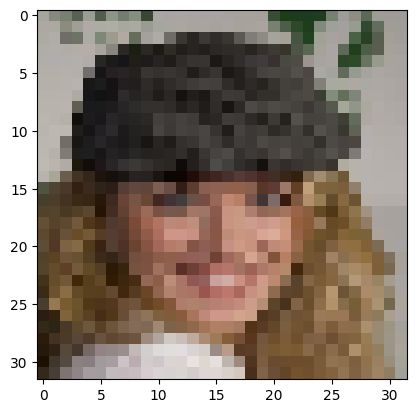

In [ ]:
for img_batch, _ in train_dataset.take(2):   # 2 batches with 64 samples (32x32x3)
  print("Dataset shape:", img_batch.shape)
  img_arr = tf.keras.utils.img_to_array(img_batch[0])
  img_arr = np.array(img_arr).astype('float32') / 255.0
  plt.imshow(img_arr)

### Standardize the data

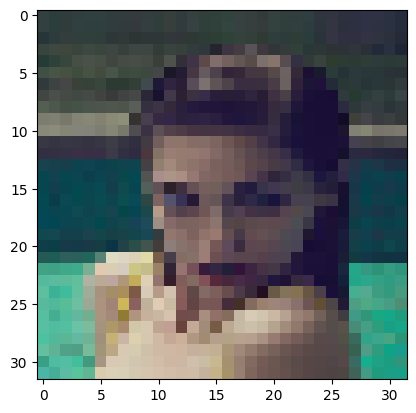

In [ ]:
from tensorflow.keras.layers import Rescaling

normalization_layer = Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

# Visualize First img
image_batch, labels_batch = next(iter(train_dataset))

first_image = image_batch[0]
plt.imshow(first_image)

In [ ]:
DISP_IMG_ROW = 6  # Total displayed images for each row
DISP_IMG_COL = 6  # Total displayed images for each column

In [ ]:
def display_images(dataset, figsize=(6,6), normalize=False, denormalize=False):
    img_list = []
    fig, axes = plt.subplots(DISP_IMG_ROW, DISP_IMG_COL, sharex=True, sharey=True, figsize=figsize,)

    for img_batch, _ in dataset.take(1):  # Get first batch of the dataset
        img_list.append(img_batch)  # (1, 64, 32, 32, 3) => (NUM_BATCH, BATCH_SIZE, WIDTH, HEIGHT, CHANNEL)

    img_list = np.array(img_list)   # (1, 64, 32, 32, 3)
    img_list = np.squeeze(img_list)  # reduce 1 dimension: (64, 32, 32, 3)

    for ix, ax in enumerate(axes.flatten()):
        # Scale image for perparing for the visualization
        if normalize:
          img = tf.keras.utils.img_to_array(img_list[ix])
          img = np.array(img).astype('float32') / 255.0
        else:
          img = img_list[ix]

        if denormalize:
            img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8) # Scale back to 0-255
        ax.imshow(img, aspect='equal')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

    plt.subplots_adjust(wspace=0, hspace=0)

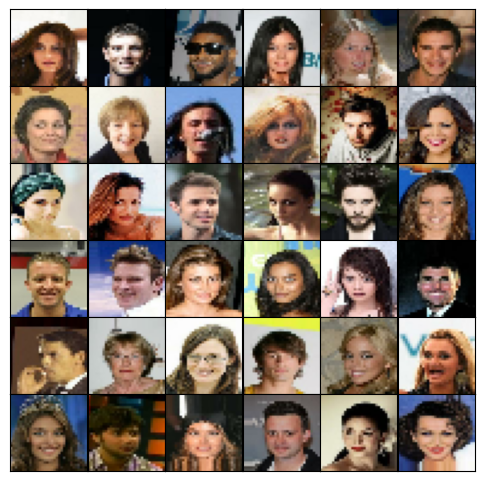

In [ ]:
display_images(train_dataset)

### Network Inputs

In [ ]:
from tensorflow.keras import Input

def model_inputs(real_dim, z_dim):
    inputs_real = Input(shape=(*real_dim,), name='input_real', dtype=tf.float32)
    inputs_z = Input(shape=(z_dim,), name='input_z', dtype=tf.float32)

    return inputs_real, inputs_z

### Auxiliary Parameters

In [ ]:
kernel_initializer_custom = tf.random_normal_initializer(mean=0.0, stddev=0.02)
# alpha = 0.3 # default
alpha = 0.2   # Leaky ReLU alpha parameter

### Generator

The network has `4 convolutional layers`. All followed by batch normalization `BN` (except for the output layer) and Rectified Linear unit (`ReLU`) activations. It takes as input a `random vector z` (drawn from a normal distribution). After reshaping z to have a 4D shape, we feed it to the generator that starts a series of upsampling layers.

Each upsampling layer represents a `transpose convolution` operation with `strides 2`. Basically, every time we move the convolutional kernel by one pixel on the input feature map, we move it by 2 or more pixels on the output map.

After each transpose convolution, z becomes wider and shallower. All transpose convolutions use a `5x5 kernel’s` size with depths reducing from `512` all the way down to `3` - representing an RGB color image.

The final layer outputs a `32x32x3` tensor squashed between values of `-1` and `1` through the Hyperbolic Tangent (`tanh`) function. Finally, we scale the input data to the interval of -1 to 1 to follow the choice of using the tanh function.

In [ ]:
'''
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Conv2DTranspose, MaxPooling2D, Flatten, ReLU, LeakyReLU, Activation, Reshape
from tensorflow.keras import Sequential, Input

def generator_seq(z, output_dim, alpha=0.2, training=True):
    """
    Generator network
    :param z: input random vector z
    :param output_dim: output dimension of the network
    :param alpha: scalar for lrelu activation function
    :param training: Boolean for controlling the batch normalization statistics
    :return: model's output
    """

    model = Sequential(
        [
            Input(shape = (z.shape[1],1)),     # TensorShape([None, 100]) => z.shape[1] = 100
            Dense(units=4*4*512, activation=None, kernel_initializer=kernel_initializer_custom),
            Reshape((4, 4, 512)),
            BatchNormalization(epsilon=1e-5, momentum=0.9, training=training),   # Apply batch normalization
            LeakyReLU(alpha),
            # ReLU(alpha),

            Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', activation=None,
                           kernel_initializer=kernel_initializer_custom),
            BatchNormalization(epsilon=1e-5, momentum=0.9, training=training),
            LeakyReLU(alpha),
            # ReLU(alpha),

            Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same'),
            BatchNormalization(epsilon=1e-5, momentum=0.9, training=training),
            LeakyReLU(alpha),
            # ReLU(alpha),

            Conv2DTranspose(output_dim, (5, 5), strides=(2, 2), padding='same'),
            Activation('tanh'),
        ]
    )
    model.summary()

    out = model(z)
    return out
'''

'\nfrom tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Conv2DTranspose, MaxPooling2D, Flatten, ReLU, LeakyReLU, Activation, Reshape\nfrom tensorflow.keras import Sequential, Input\n\ndef generator_seq(z, output_dim, alpha=0.2, training=True):\n    """\n    Generator network\n    :param z: input random vector z\n    :param output_dim: output dimension of the network\n    :param alpha: scalar for lrelu activation function\n    :param training: Boolean for controlling the batch normalization statistics\n    :return: model\'s output\n    """\n\n    model = Sequential(\n        [\n            Input(shape = (z.shape[1],1)),     # TensorShape([None, 100]) => z.shape[1] = 100\n            Dense(units=4*4*512, activation=None, kernel_initializer=kernel_initializer_custom),\n            Reshape((4, 4, 512)),\n            BatchNormalization(epsilon=1e-5, momentum=0.9, training=training),   # Apply batch normalization\n            LeakyReLU(alpha),\n            # ReLU(alpha),\n\

In [ ]:
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Conv2DTranspose, MaxPooling2D, Flatten, ReLU, LeakyReLU, Activation, Reshape
from tensorflow.keras import Sequential, Input

def get_generator_model(z, output_dim, alpha=0.2):
    """
    Generator network
    :param z: input random vector z
    :param output_dim: output dimension of the network
    :param alpha: scalar for lrelu activation function
    :return: model's output
    """
    model = Sequential()
    model.add(Input(shape=(z.shape[1],)))  # TensorShape([None, 100]) => z.shape[1] = 100
    model.add(Dense(units=4*4*512, activation=None, kernel_initializer=kernel_initializer_custom))
    model.add(Reshape((4, 4, 512)))
    assert model.output_shape == (None, 4, 4, 512)  # Note: None is the batch size
    model.add(BatchNormalization(epsilon=1e-5, momentum=0.9))
    model.add(LeakyReLU(alpha))

    model.add(Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', activation=None, kernel_initializer=kernel_initializer_custom))
    # assert model.output_shape == (None, 4, 4, 512)  # Calculate output shape
    model.add(BatchNormalization(epsilon=1e-5, momentum=0.9))
    model.add(LeakyReLU(alpha))

    model.add(Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(BatchNormalization(epsilon=1e-5, momentum=0.9))
    model.add(LeakyReLU(alpha))

    model.add(Conv2DTranspose(output_dim, (5, 5), strides=(2, 2), padding='same', activation='tanh'))

    model.summary()
    # Return output
    # out = model(z)
    # return out

    # Return model
    return model

In [ ]:
# real_size = dataset.images().shape[1:]
(img_batch, labels_batch) = next(iter(train_dataset))
real_size = img_batch.shape[1:]  # (64, 32, 32, 3) -> (32, 32, 3)
noise_size = 100

In [ ]:
input_real, input_noise = model_inputs(real_size, noise_size)
print(f"input_real.shape: {input_real.shape}\ninput_z.shape: {input_noise.shape}")

input_real.shape: (None, 32, 32, 3)
input_z.shape: (None, 100)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 8192)              827392    
                                                                 
 reshape_2 (Reshape)         (None, 4, 4, 512)         0         
                                                                 
 batch_normalization_5 (Batc  (None, 4, 4, 512)        2048      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 8, 8, 256)        3277056   
 ranspose)                                                       
                                                                 
 batch_normalization_6 (Batc  (None, 8, 8, 256)       

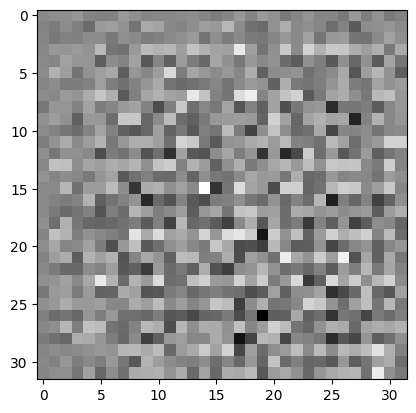

In [ ]:
generator_model = get_generator_model(input_noise, 3)

noise = tf.random.normal([1, 100])
generated_image = generator_model(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### Discriminator

The discriminator acts as a regular `binary classifier`. Half of the time it receives images from the training set and the other half from the generator. The discriminator notices a difference between the real and fake images, it sends a signal to the generator. This signal is the gradient that flows from the discriminator to the generator. By receiving it, the generator is able to adjust its parameters to get closer to the true data distribution. We want the discriminator to be able to distinguish between real and fake images. `Every` time we run a mini-`batch` through the `discriminator`, we get `logits`. These are the `unscaled values` from the model. However, we can divide the mini-batches that the discriminator receives in `two types`. The First, composed only with `real images` that come from the training set and the second, with only `fake images` a.k.a. the ones created by the generator.

In [ ]:
generated_image.shape[1:]

TensorShape([32, 32, 3])

In [ ]:
def get_discriminator_model(input, alpha=0.2):
    """
    Discriminator network
    :param input: input for network
    :param alpha: scalar for lrelu activation function
    :return: A tuple of (sigmoid probabilities, logits)
    """
    model = Sequential()
    model.add(Input(shape=input.shape[1:]))  # TensorShape([1, 32, 32, 3]) to TensorShape([32, 32, 3])
    model.add(Conv2D(64, kernel_size=5, strides=2, padding="same", activation=None, kernel_initializer=kernel_initializer_custom))
    model.add(LeakyReLU(alpha))

    model.add(Conv2D(128, kernel_size=5, strides=2, padding="same", activation=None, kernel_initializer=kernel_initializer_custom))
    model.add(BatchNormalization(epsilon=1e-5, momentum=0.9))
    model.add(LeakyReLU(alpha))

    model.add(Conv2D(256, kernel_size=5, strides=2, padding="same", activation=None, kernel_initializer=kernel_initializer_custom))
    model.add(BatchNormalization(epsilon=1e-5, momentum=0.9))
    model.add(LeakyReLU(alpha))

    # Flatten it
    model.add(Reshape((4, 4, 256)))
    assert model.output_shape == (None, 4, 4, 256)  # Note: None is the batch size

    model.add(Flatten())   # 4*4*256
    # model.add(Dense(1, kernel_initializer=kernel_initializer_custom, activation='sigmoid'))
    model.add(Dense(1, kernel_initializer=kernel_initializer_custom, activation=None))  # from logist: TRUE
    # Return output
    # logits = model(x)

    model.summary()

    # Return output
    # out = model(x)
    # return out, logits

    # Return model
    return model

In [ ]:
'''
def get_discriminator_model(input, alpha=0.2):
    model = tf.keras.Sequential()
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[32, 32, 1]))
    model.add(LeakyReLU())
    model.add(keras.layers.Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(keras.layers.Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1))

    return model
'''

"\ndef get_discriminator_model(input, alpha=0.2):\n    model = tf.keras.Sequential()\n    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same',\n                                     input_shape=[32, 32, 1]))\n    model.add(LeakyReLU())\n    model.add(keras.layers.Dropout(0.3))\n\n    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))\n    model.add(LeakyReLU())\n    model.add(keras.layers.Dropout(0.3))\n\n    model.add(Flatten())\n    model.add(Dense(1))\n\n    return model\n"

In [ ]:
discriminator_model = get_discriminator_model(generated_image)
decision = discriminator_model(generated_image)
print (decision)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 16, 16, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 batch_normalization_10 (Bat  (None, 8, 8, 128)        512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 conv2d_8 (Conv2D)           (None, 4, 4, 256)         819456    
                                                      

### Training [DCGAN model](https://arxiv.org/abs/1511.06434)

Because both networks train at the same time, GANs also need `two optimizers`. Each one for `minimizing` the `discriminator and generator’s loss` functions respectively. We want the discriminator to output probabilities close to `1` for `real` images and near `0` for `fake` images. To do that, the discriminator needs two losses. Therefor, the total loss for the discriminator is the `sum of these two partial losses`. One for maximizing the probabilities for the real images and another for minimizing the probability of fake images.


In the beginning discriminator receives `two` very `distinct` types of `batches`. One, composed of `true images` from the training set and another containing very `noisy signals`. As training progresses, the generator starts to output images that look closer to the images from the training set. At the same time, the discriminator starts to get real good at classifying samples as real or fake. As a consequence, the two types of mini-batches begin looking similar, in structure, to one another.

In this paper, `vanilla cross-entropy` with `Adam` was used as optimizer for the losses.

In [ ]:
EPOCHS = 1

### Define Loss and Optimizers

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss

The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### Optimizers

In [ ]:
# LEARNING_RATE = 1e-4
LEARNING_RATE = 0.0002  # Reference paper: https://arxiv.org/abs/1511.06434
BETA_1 = 0.5  # Reference paper: https://arxiv.org/abs/1511.06434

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=BETA_1)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=BETA_1)

### Save Checkpoint

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator_model,
                                 discriminator=discriminator_model)

### Training Loop

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [ ]:
EPOCHS = 5
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  # TensorShape[64, 100]

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator_model(noise, training=True)

      real_output = discriminator_model(images, training=True)
      fake_output = discriminator_model(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)  # Returns the sum of real_loss and fake_loss

    gradients_of_generator = gen_tape.gradient(gen_loss, generator_model.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator_model.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator_model.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator_model.trainable_variables))

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # `training` is set to False.
  predictions = model(test_input, training=False)  # Inference mode

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      # plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')  # denormalize
      plt.imshow(predictions[i, :, :, 0] * 255)  # denormalize - TODO: Use normalization as above, this type of normalization causes value range warnings in matplotlib
      plt.axis('off')   # No axis, show only image

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
import time
from IPython import display

def train(dataset, epochs):
  for epoch in range(epochs):
    start_time = time.time()

    for image_batch, _ in dataset:
        train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator_model, epoch + 1, seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start_time))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator_model, epochs, seed)

### Train the Model

Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real.

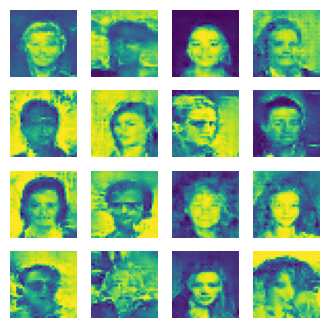

In [ ]:
train(train_dataset, EPOCHS)

### Create GIF

In [ ]:
# To generate GIFs
! pip install imageio
! pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-th1rtz5i
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-th1rtz5i
  Resolved https://github.com/tensorflow/docs to commit 97ac0aea73f1cf802004049f92bd3a985010d7e5
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2023.9.4.19335-py3-none-any.whl size=184104 sha256=0a9875321d8d4fe14687d72b968aa71c3915ded39fbada4fcfb9ab275a790e02
  Stored in directory: /tmp/pip-ephem-wheel-cache-agluh1ht/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

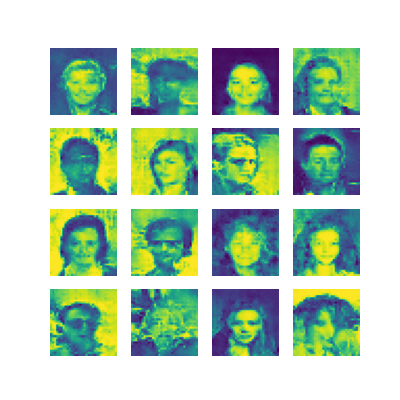

In [ ]:
display_image(EPOCHS)

In [ ]:
import imageio
import glob

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-74-d01179c675ce>:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-74-d01179c675ce>:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



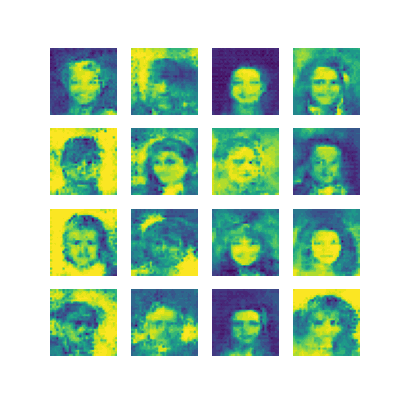

In [ ]:
import tensorflow_docs.vis.embed as embed

embed.embed_file(anim_file)

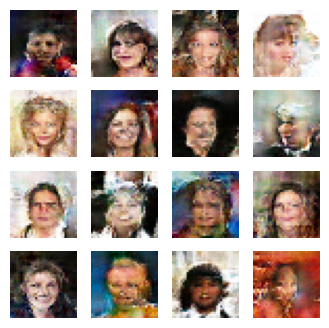

In [ ]:
sample = tf.random.normal([16, noise_dim])

predictions = generator_model(sample, training=False)  # Inference mode

fig = plt.figure(figsize=(4, 4))

for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(predictions[i, :, :])  # denormalize
    plt.axis('off')   # No axis, show only image

plt.savefig('image_sample.png')
plt.show()

There are some warnings while showing predictions due to having non-positive values in data caused by the usage of LeakReLU.

In [ ]:
print(f"Minimum value in the prediction data: {np.min(predictions)}\nMaximum value in the prediction data: {np.max(predictions)}" )

Minimum value in the prediction data: -0.2304440438747406
Maximum value in the prediction data: 0.9999985098838806


### Reference

https://sthalles.github.io/intro-to-gans/

https://www.tensorflow.org/tutorials/generative/dcgan

[Deep Convolutional Generative Adversarial Network (DCGAN)](https://arxiv.org/abs/1511.06434)

https://github.com/sthalles/blog-resources/blob/master/dcgan/DCGAN.ipynb

Dataset: http://ufldl.stanford.edu/housenumbers/

Citation:

@article{
  silva2017GANs,
  title={A Short Introduction to Generative Adversarial Networks},
  author={Silva, Thalles Santos},
  journal={https://sthalles.github.io},
  year={2017},
  url={https://sthalles.github.io/intro-to-gans/}
}